# 预测北京房价
北京房价数据集中 bj_housing.csv。

**这个数据集的特征有：**
* Area：房屋面积，平方米
* Room：房间数，间
* Living: 厅数，间
* School: 是否为学区房，0或1
* Year: 房屋建造时间，年
* Floor: 房屋所处楼层，层

**目标变量：**
* Value: 房屋人民币售价，万

你可以参考上面学到的内容，拿这个数据集来练习数据分割与重排、定义衡量标准、训练模型、评价模型表现、使用网格搜索配合交叉验证对参数进行调优并选出最佳参数，比较两者的差别，最终得出最佳模型对验证集的预测分数。

## 第一步. 载入数据
首先，载入数据集，并返回数据集的大小

In [3]:
#载入项目需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import visuals as vs

#检查python版本
from sys import version_info
if version_info.major != 2 or version_info.minor != 7:
    raise Exception('请使用Python 2.7')

# 让结果在notebook中显示
%matplotlib inline

In [4]:
# 载入北京房价数据集
data = pd.read_csv('bj_housing.csv')
prices = data['Value']
features = data.drop('Value', axis=1)

print "Beijing housing dataset has {} data points with {} variables each".format(*data.shape)

Beijing housing dataset has 9999 data points with 7 variables each


## 第二步. 分析数据
### 1. 数据去重
对于DataFrame格式的数据，可以直接使用drop_duplicates方法，返回一个移除了重复行的DataFrame。

In [5]:
data = data.drop_duplicates()

print data.shape

(6716, 7)


> 发现数据去重是非常有必要的，本来9999条数据，竟然有3200多条数据重复。

### 2. 简单的统计分析
用pandas的**describe()方法**，可以快速的对数据进行一个简单的描述性统计分析，对数据的取值有一个直观的认识。

In [6]:
data.describe()

,Area,Value,Room,Living,School,Year,Floor
count,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000,6716.000000
mean,92.257594,342.385795,2.164235,1.284098,0.582341,1998.269506,13.275908
std,46.811942,257.532236,0.796105,0.525726,0.493210,14.756803,7.994895
min,14.000000,66.000000,1.000000,0.000000,0.000000,1014.000000,0.000000
25%,61.000000,205.000000,2.000000,1.000000,0.000000,1994.000000,6.000000
50%,83.000000,277.500000,2.000000,1.000000,1.000000,2000.000000,12.000000
75%,110.000000,396.000000,3.000000,2.000000,1.000000,2004.000000,19.000000
max,1124.000000,7450.000000,9.000000,4.000000,1.000000,2015.000000,91.000000


我们也可以用numpy模块对目标变量**房价**`'Value'`的统计数据进行分析。
* 用numpy模块计算`prices`中`'Value'`的最大值、最小值、均值、中值和标准差

In [7]:
prices_2d = np.matrix(prices)
min_price = prices_2d.min()
max_price = prices_2d.max()
mean_price = prices_2d.mean()
median_price = np.median(prices)
std_price = np.std(prices)

print "Statistics for Beijing housing dataset:\n"
print "Minimum price: ￥{:,.2f}".format(10000 * min_price)
print "Maximum price: ￥{:,.2f}".format(10000 * max_price)
print "Mean price: ￥{:,.2f}".format(10000 * mean_price)
print "Median price: ￥{:,.2f}".format(10000 * median_price)
print "Standard deviation of prices: ￥{:,.2f}".format(10000 * std_price)

Statistics for Beijing housing dataset:

Minimum price: ￥660,000.00
Maximum price: ￥74,500,000.00
Mean price: ￥3,420,762.08
Median price: ￥2,800,000.00
Standard deviation of prices: ￥2,593,930.56


### 2. 分割数据
将数据分割成训练与测试两个子集。这个过程中，数据会被重新排列，以消除数据集中由于顺序而产生的偏差。
* 分割比例为：80%用于训练，20%用于测试
* 选定一个数值设定train_test_split中的random_state，确保结果的一致性

In [8]:
from sklearn.model_selection import train_test_split, ShuffleSplit

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=10)

## 第三步. 定义衡量标准
本项目中，通过[决定系数](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination)R<sup>2</sup>来量化模型的表现。模型的决定系数是回归分析中十分常用的统计信息，经常被当作衡量模型预测能力好坏的标准。

R<sup>2</sup>的数值范围从0至1，表示**目标变量**的预测值和实际值之间的相关程度平方的百分比。一个模型的R<sup>2</sup> 值为0还不如直接用**平均值**来预测效果好；而一个R<sup>2</sup> 值为1的模型则可以对目标变量进行完美的预测。从0至1之间的数值，则表示该模型中目标变量中有百分之多少能够用**特征**来解释。_模型也可能出现负值的R<sup>2</sup>，这种情况下模型所做预测有时会比直接计算目标变量的平均值差很多。_

In [9]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

## 第四步. 分析模型表现
先看看不同参数在训练集和验证集上的表现。

模型选择决策树回归，关注算法中的`'max_depth'`。画出模型的表现，让分析更加直观。

### 学习曲线 learning curve
写一个方法`'plot_learning_curve'`，绘出梯度提升树GBDT模型在不同最大深度下的表现。每一条曲线都直观得显示了随着训练数据量的增加，模型学习曲线的在训练集评分和验证集评分的变化，评分使用决定系数R2。曲线的阴影区域代表的是该曲线的不确定性（用标准差衡量）。

In [11]:
import matplotlib.pyplot as pl
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.ensemble import GradientBoostingRegressor

def plot_learning_curve(X, y):
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)


    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create four different models based on max_depth
    for k, depth in enumerate([1,4,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = GradientBoostingRegressor(max_depth=depth, random_state = 10)

        # Calculate the training and testing scores
        sizes, train_scores, valid_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        valid_std = np.std(valid_scores, axis = 1)
        valid_mean = np.mean(valid_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, valid_mean, 'o-', color = 'g', label = 'Validation Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, valid_mean - valid_std, \
            valid_mean + valid_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('r2_score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Gradient Boosting Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()


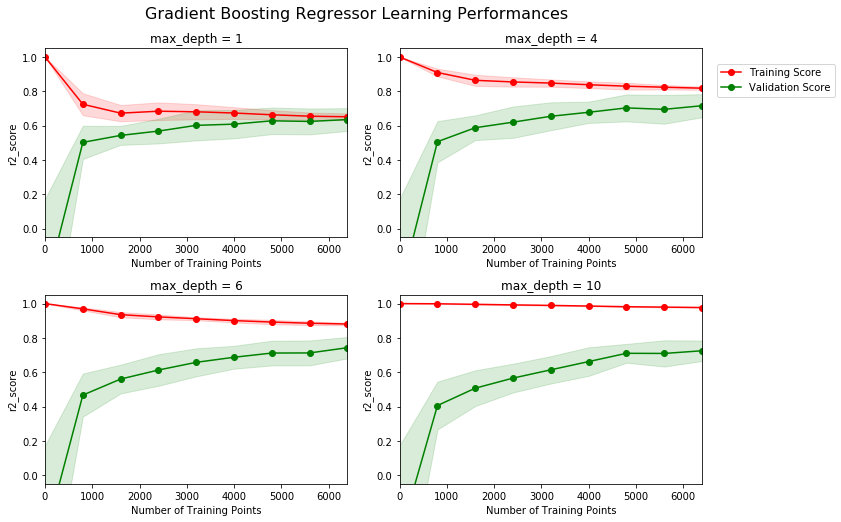

In [12]:
plot_learning_curve(X_train, y_train)

### 复杂度曲线
下列代码内的区域会输出一幅图像，它展示了一个已经经过训练和验证的决策树模型在不同最大深度条件下的表现。这个图形将包含两条曲线，一个是训练集的变化，一个是验证集的变化。跟**学习曲线**相似，阴影区域代表该曲线的不确定性，模型训练和测试部分的评分都用的 `performance_metric` 函数。

In [13]:
def plot_model_complexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and validation errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, valid_scores = validation_curve(GradientBoostingRegressor(random_state = 10), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, valid_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, valid_mean - valid_std, \
        valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('r2_score')
    pl.ylim([-0.05,1.05])
    pl.show()


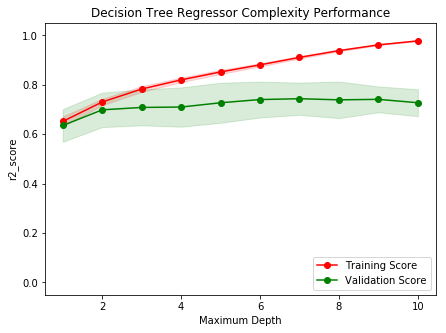

In [14]:
# 根据不同的最大深度参数，生成复杂度曲线
plot_model_complexity(X_train, y_train)

## 第五步. 选择最优参数
### K折交叉验证 + 网格搜索
**K折交叉验证法**，将数据集划分为k个大小相似的互斥子集，每次用（k-1）个子集的并集作为训练集，余下的那个子集作为测试集，这样可以获得k组训练/测试集，进行k次训练测试之后返回k个测试结果的均值。

**网格搜索（Grid Search）**，是指通过遍历的方法，运行给定的所有参数组合，根据需要选择合适的评分方式（如accuracy、precision、recall、F1分数等）
> 交叉验证可以获得K组训练/测试集，得到的是k次测试的平均值。这样得到的结果更稳定可靠。

利用[GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)方法进行调参。使用梯度提升树算法训练一个回归模型，找到最佳的`'max_depth'和'n_estimators'`参数。

1. **定义 `'cross_validator'` 变量**: 使用 `sklearn.model_selection` 中的 [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) 创建一个交叉验证生成器对象;
2. **定义 `'regressor'` 变量**: 使用  `sklearn.ensemble` 中的 [`GradientBoostingRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) 创建一个GBDT的回归函数;
3. **定义 `'params'` 变量**: 为 `'max_depth'、'n_estimators'` 参数创造一个字典;
4. **定义 `'scoring_fnc'` 变量**: 使用 `sklearn.metrics` 中的 [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)  创建一个评分函数；
 将 `‘performance_metric’` 作为参数传至这个函数中；
5. **定义 `'grid'` 变量**: 使用 `sklearn.model_selection` 中的 [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 创建一个网格搜索对象；将变量`'regressor'`, `'params'`, `'scoring_fnc'`和 `'cross_validator'` 作为参数传至这个对象构造函数中；

In [19]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingRegressor

def fit_model(X, y, regressor, params):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(n_splits = 10)

    scoring_fnc = make_scorer(performance_metric)

    grid = GridSearchCV(regressor, params, scoring = scoring_fnc, cv = cross_validator, n_jobs=2)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
    
    #print pd.DataFrame(grid.cv_results_)
    #print grid.best_estimator_

    # 返回网格搜索后的最优模型
    return grid.best_estimator_

将梯度提升树回归函数带入训练数据的集合，得到最优化模型。

In [31]:
# 基于训练数据，获得最优模型
regressor = GradientBoostingRegressor(learning_rate=0.1, random_state = 10)
params = {'n_estimators':range(50,301,20), 'max_depth':range(2,10)}
optimal_reg = fit_model(X_train, y_train, regressor, params)

# 输出最优模型的参数
print "Parameter for the optimal model: \n"
print optimal_reg

Parameter for the optimal model: 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=290, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False)


最大深度取6，迭代次数"n_estimators"取290时为优化后的参数，此时计算决定系数R<sup>2</sup>，发现为0.75，比单纯用决策树的0.63增加12%。

进一步优化内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf。

In [22]:
regressor = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=6, random_state = 10)
params = {'min_samples_split':range(2,200,20), 'min_samples_leaf':range(1,100,10)}
optimal_reg = fit_model(X_train, y_train, regressor, params)

# 输出最优模型的参数
print "Parameter for the optimal model: \n"
print optimal_reg

Parameter for the optimal model: 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False)


发现这两个值并不会造成影响，仍然取默认值min_samples_leaf=1，min_samples_split=2。

## 第六步. 做出预测
我们已经用数据训练出了一个模型，现在用它来对测试集的数据进行预测。测试集的数据是第二步中分割出的test数据，是不包含在训练数据之内的。


### 计算决定系数 R<sup>2</sup>

In [33]:
pred = optimal_reg.predict(X_test)

r2 = performance_metric(y_test, pred)

print "Optimal model has R^2 score {:,.2f} on test data".format(r2)

Optimal model has R^2 score 0.75 on test data


### 模型健壮性
采用不同的训练和测试集执行fit_model函数10次。观察对于一个特定的客户，预测是如何随训练数据的变化而变化的。

In [36]:
def PredictTests(X, y, fitter, data):
    """ Performs testss of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # Fit the data
        regressor = GradientBoostingRegressor(learning_rate=0.1, random_state = 10)
        params = {'n_estimators':range(150,301,50), 'max_depth':range(5,7)}
        reg = fitter(X_train, y_train, regressor, params)
        
        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)
        
        # Result
        print "Trial {}: ￥{:,.2f}".format(k+1, pred * 10000)    #单位是万元

    # Display price range
    print "\nRange in prices: ￥{:,.2f}".format(10000*(max(prices) - min(prices)))


In [ ]:
client_data = [[100, 3, 1, 0, 2012, 15]]       #给定一个客户的数据
PredictTests(features, prices, fit_model, client_data)

Trial 1: ￥2,446,729.91
Trial 2: ￥2,907,194.75
Trial 3: ￥2,888,682.23
Trial 4: ￥2,797,435.78
Trial 5: ￥3,937,383.69
Trial 6: ￥2,492,198.33
Trial 7: ￥2,809,306.45
Trial 8: ￥2,706,569.61


### 结论
采用梯度提升树GBDT作为模型，预测的决定系数R<sup>2</sup>更高，为0.75，相对于仅仅用决策树回归算法提升0.12。

模型的健壮性更强。单纯采用决策树，重复预测波动达到±27%，GBDT剔除异常的5号之后，波动为±9%。